In [1]:
import os
import re
import pandas as pd
from glob import glob

from typing import List, Tuple, Dict, Any, Union

os.chdir('/shared/nas2/xingyao6/projects/Multimodal-Mistral')

In [2]:
data_files = glob("data/processed/megatron_format/mmistral_*/data.jsonl")
data_files = sorted(data_files)
print(f"{len(data_files)} data files found")

# filter those where data_DONE exist in the same directory
data_files = [f for f in data_files if os.path.exists(f.replace("data.jsonl", "data_DONE"))]
print(f"{len(data_files)} data files to process (data_DONE exist)")

204 data files found
204 data files to process (data_DONE exist)


In [3]:
def aggregate_data(data_files, data_key, shard_ids=None):
    data = []
    for f in data_files:
        if data_key in f:
            # print(f)
            # if shard_ids is not empty, only process files with shard_id in the filename
            if shard_ids and f and not re.search(r"shard_(\d+)", f).group(1) in shard_ids:
                continue
            _cur_df = pd.read_json(f, lines=True)
            _cur_df["filepath"] = f
            _cur_df["n_text_tokens"] = _cur_df["n_tokens"] - _cur_df["n_image_tokens"]
            data.append(_cur_df)
    print(f"{len(data)} data files found with data_key={data_key}")
    data = pd.concat(data)
    return data

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_stats(stats: pd.DataFrame):

    display(pd.concat([
        stats.describe(),
        stats[["n_tokens", "n_text_tokens", "n_image_tokens", "n_images"]].sum().to_frame("total").T
    ], axis=0).style.background_gradient(cmap="viridis", axis=1).format("{:,.0f}"))

    if stats["filepath"].nunique() > 1:
        print("Multiple data files found. Showing total token breakdown by file")
        display(stats.groupby("filepath")[["n_tokens", "n_text_tokens", "n_image_tokens", "n_images"]].sum().style.background_gradient(cmap="viridis", axis=1).format("{:,.0f}"))

    # plot 3 ecdf subplots for each of the 3 metrics: n_tokens, n_image_tokens, n_images
    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    for i, metric in enumerate(["n_tokens", "n_text_tokens", "n_image_tokens", "n_images"]):
        sns.ecdfplot(stats[metric], ax=ax[i])
        # set x-axis to fixed range
        ax[i].set_xlim(0, stats[metric].max())
        ax[i].set_title(f"ECDF of {metric}")
    plt.show()

# visualize_stats(stats)

## Training Datasets

128 data files found with data_key=mmistral_capfusion_shard_


,n_tokens,n_image_tokens,n_images,n_text_tokens
count,"817,249","817,249","817,249","817,249"
mean,"32,513","26,791",116,"5,722"
std,324,521,10,454
min,745,652,2,93
25%,"32,391","26,479",109,"5,417"
50%,"32,590","26,809",115,"5,711"
75%,"32,696","27,125",122,"6,013"
max,"32,768","29,193",198,"9,207"
total,"26,571,198,868","21,894,842,130","94,427,830","4,676,356,738"


Multiple data files found. Showing total token breakdown by file


,n_tokens,n_text_tokens,n_image_tokens,n_images
filepath,,,,
data/processed/megatron_format/mmistral_capfusion_shard_000_pack32k/data.jsonl,"207,815,782","36,655,853","171,159,929","740,163"
data/processed/megatron_format/mmistral_capfusion_shard_001_pack32k/data.jsonl,"206,774,364","36,571,627","170,202,737","739,583"
data/processed/megatron_format/mmistral_capfusion_shard_002_pack32k/data.jsonl,"208,615,428","36,747,426","171,868,002","740,771"
data/processed/megatron_format/mmistral_capfusion_shard_003_pack32k/data.jsonl,"206,227,749","36,568,754","169,658,995","739,404"
data/processed/megatron_format/mmistral_capfusion_shard_004_pack32k/data.jsonl,"208,920,072","36,745,513","172,174,559","741,079"
data/processed/megatron_format/mmistral_capfusion_shard_005_pack32k/data.jsonl,"210,832,912","36,765,302","174,067,610","741,748"
data/processed/megatron_format/mmistral_capfusion_shard_006_pack32k/data.jsonl,"207,911,194","36,609,107","171,302,087","739,923"
data/processed/megatron_format/mmistral_capfusion_shard_007_pack32k/data.jsonl,"208,287,357","36,663,998","171,623,359","740,591"
data/processed/megatron_format/mmistral_capfusion_shard_008_pack32k/data.jsonl,"210,584,435","36,796,178","173,788,257","741,689"


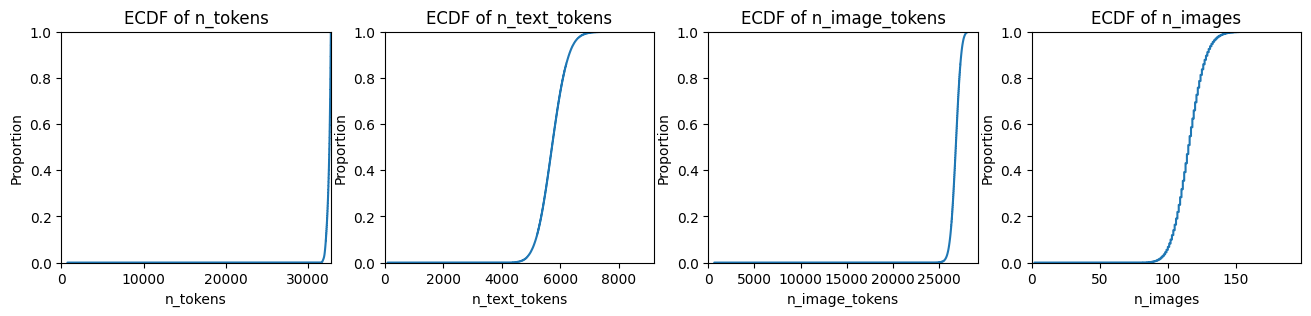

In [5]:
capfusion = aggregate_data(data_files, "mmistral_capfusion_shard_")
visualize_stats(capfusion)

1 data files found with data_key=mmistral_detailed_captions_shard_


,n_tokens,n_image_tokens,n_images,n_text_tokens
count,"6,225","6,225","6,225","6,225"
mean,"32,452","25,258",59,"7,195"
std,256,382,3,328
min,"22,119","17,639",35,"4,480"
25%,"32,325","25,020",57,"6,974"
50%,"32,492","25,260",59,"7,195"
75%,"32,627","25,510",61,"7,417"
max,"32,768","26,833",70,"8,687"
total,"202,016,770","157,228,570","368,767","44,788,200"


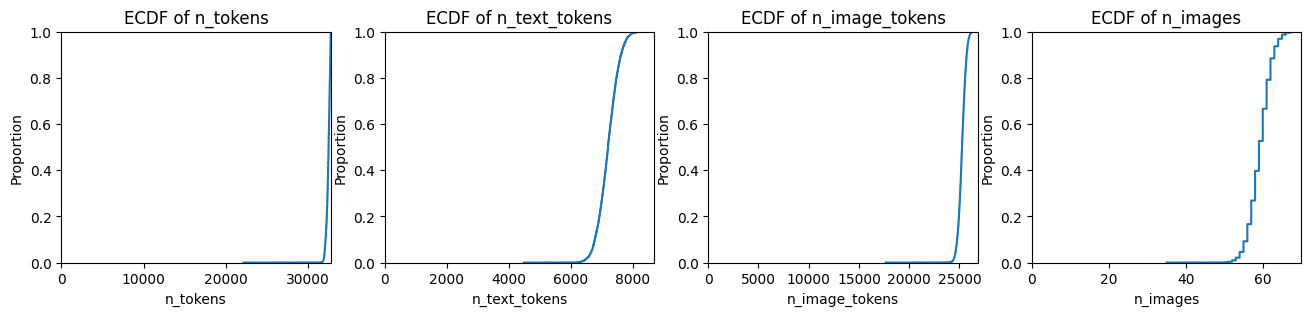

In [7]:
detailed_caption = aggregate_data(data_files, "mmistral_detailed_captions_shard_")
visualize_stats(detailed_caption)

9 data files found with data_key=mmistral_cc3m_full_shard_


,n_tokens,n_image_tokens,n_images,n_text_tokens
count,"32,760","32,760","32,760","32,760"
mean,"32,493","30,170",71,"2,323"
std,336,326,4,96
min,"4,956","4,556",12,400
25%,"32,382","30,049",69,"2,260"
50%,"32,539","30,204",71,"2,322"
75%,"32,654","30,327",74,"2,386"
max,"32,768","30,711",86,"2,698"
total,"1,064,477,314","988,385,167","2,331,439","76,092,147"


Multiple data files found. Showing total token breakdown by file


,n_tokens,n_text_tokens,n_image_tokens,n_images
filepath,,,,
data/processed/megatron_format/mmistral_cc3m_full_shard_000_pack32k/data.jsonl,"118,693,135","8,485,324","110,207,811","260,115"
data/processed/megatron_format/mmistral_cc3m_full_shard_001_pack32k/data.jsonl,"118,554,998","8,480,315","110,074,683","259,625"
data/processed/megatron_format/mmistral_cc3m_full_shard_002_pack32k/data.jsonl,"118,371,797","8,455,952","109,915,845","259,139"
data/processed/megatron_format/mmistral_cc3m_full_shard_003_pack32k/data.jsonl,"118,648,756","8,479,185","110,169,571","259,824"
data/processed/megatron_format/mmistral_cc3m_full_shard_004_pack32k/data.jsonl,"118,855,962","8,500,136","110,355,826","260,310"
data/processed/megatron_format/mmistral_cc3m_full_shard_005_pack32k/data.jsonl,"118,647,069","8,478,301","110,168,768","259,771"
data/processed/megatron_format/mmistral_cc3m_full_shard_006_pack32k/data.jsonl,"118,588,698","8,478,191","110,110,507","259,901"
data/processed/megatron_format/mmistral_cc3m_full_shard_007_pack32k/data.jsonl,"118,722,124","8,487,326","110,234,798","260,003"
data/processed/megatron_format/mmistral_cc3m_full_shard_008_pack32k/data.jsonl,"115,394,775","8,247,417","107,147,358","252,751"


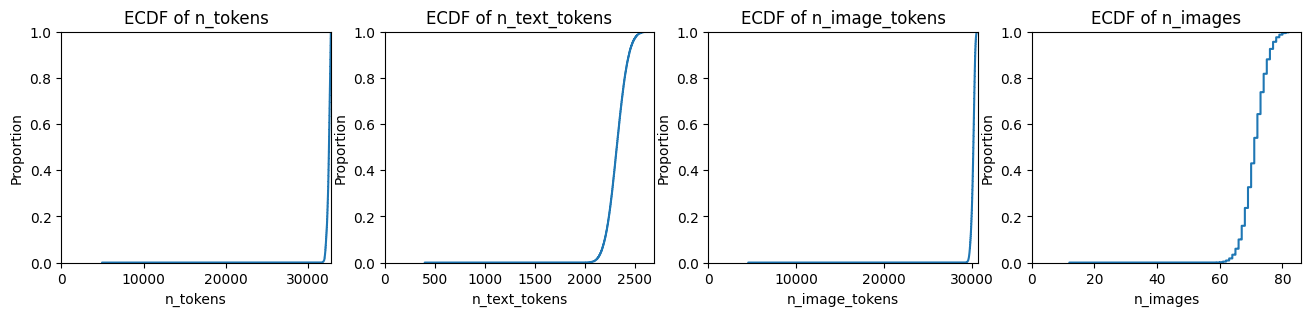

In [8]:
cc3m_full = aggregate_data(data_files, "mmistral_cc3m_full_shard_")
visualize_stats(cc3m_full)

In [ ]:
# Other source datasets:

# figureqa = aggregate_data(data_files, "mmistral_figureqa_pack32k")
# visualize_stats(figureqa)
# dvqa = aggregate_data(data_files, "mmistral_dvqa_pack32k")
# visualize_stats(dvqa)
# llavaR = aggregate_data(data_files, "mmistral_llavaR_pack32k")
# visualize_stats(llavaR)
# ocrvqa = aggregate_data(data_files, "mmistral_ocrvqa_pack32k")
# visualize_stats(ocrvqa)
# websight = aggregate_data(data_files, "mmistral_websight_shard_")
# visualize_stats(websight)
# allava_laion4v = aggregate_data(data_files, "mmistral_allava_laion4v_pack32k")
# visualize_stats(allava_laion4v)
# allava_vflan4v = aggregate_data(data_files, "mmistral_allava_vflan4v_pack32k")
# visualize_stats(allava_vflan4v)

### Text

1 data files found with data_key=mmistral_slimpajama_shard_


,n_tokens,n_image_tokens,n_images,n_text_tokens
count,"120,849","120,849","120,849","120,849"
mean,"35,947",0,0,"35,947"
std,"46,029",0,0,"46,029"
min,46,0,0,46
25%,"26,964",0,0,"26,964"
50%,"31,636",0,0,"31,636"
75%,"32,549",0,0,"32,549"
max,"4,190,363",0,0,"4,190,363"
total,"4,344,110,111",0,0,"4,344,110,111"


/tmp/ipykernel_3201505/3560877793.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[i].set_xlim(0, stats[metric].max())
/tmp/ipykernel_3201505/3560877793.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[i].set_xlim(0, stats[metric].max())


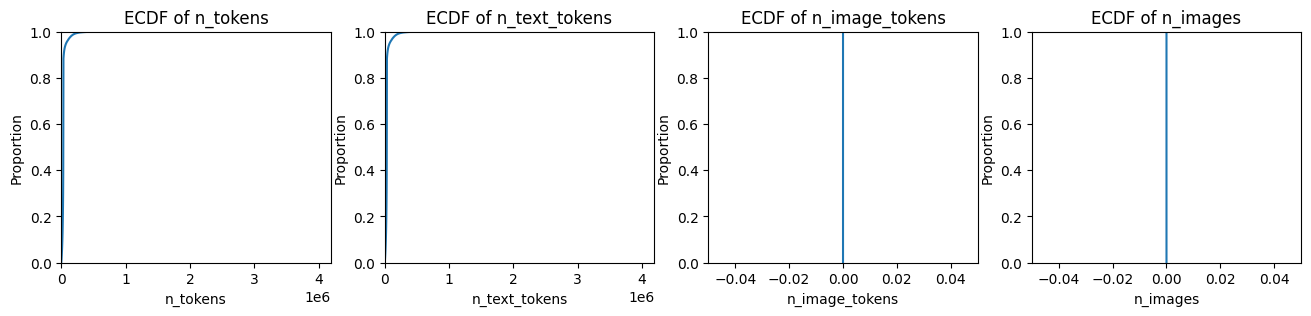

In [9]:
slimpajama_shard000 = aggregate_data(data_files, "mmistral_slimpajama_shard_", shard_ids={"000"})
visualize_stats(slimpajama_shard000)

1 data files found with data_key=mmistral_slimpajama_shard_


,n_tokens,n_image_tokens,n_images,n_text_tokens
count,"120,385","120,385","120,385","120,385"
mean,"35,727",0,0,"35,727"
std,"48,202",0,0,"48,202"
min,38,0,0,38
25%,"26,994",0,0,"26,994"
50%,"31,646",0,0,"31,646"
75%,"32,548",0,0,"32,548"
max,"6,947,482",0,0,"6,947,482"
total,"4,300,998,161",0,0,"4,300,998,161"


/tmp/ipykernel_3201505/3560877793.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[i].set_xlim(0, stats[metric].max())
/tmp/ipykernel_3201505/3560877793.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[i].set_xlim(0, stats[metric].max())


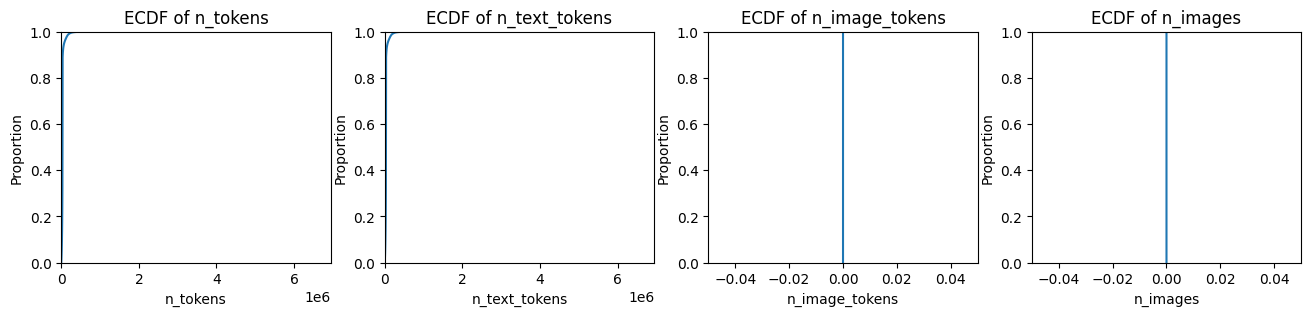

In [10]:
slimpajama_shard001 = aggregate_data(data_files, "mmistral_slimpajama_shard_", shard_ids={"001"})
visualize_stats(slimpajama_shard001)


## Create Mixture for Training

In [12]:
# dataset1-weight dataset1-path dataset2-weight dataset2-path ...

def generate_data_prefix_with_weights(mixture_stats: List[Tuple[pd.DataFrame, float]]):
    # assert all weights sum to 1
    assert sum([w for _, w in mixture_stats]) == 1.0, "Weights do not sum to 1"

    ret_mixture_stats = []
    for data_stats, weight in mixture_stats:
        # calculate the total number of tokens for each data file
        n_tokens_by_file = data_stats.groupby("filepath")[["n_tokens", "n_text_tokens", "n_image_tokens", "n_images"]].agg(
            n_tokens=("n_tokens", "sum"),
            n_instances=("n_tokens", "count"),
            n_text_tokens=("n_text_tokens", "sum"),
            n_image_tokens=("n_image_tokens", "sum"),
            n_images=("n_images", "sum")
        ).reset_index()[["filepath", "n_tokens", "n_instances", "n_text_tokens", "n_image_tokens", "n_images"]]
        # weights are proportional to the number of tokens in each file (ALL SUM TO 1)
        n_tokens_by_file["weight"] = n_tokens_by_file["n_tokens"] / n_tokens_by_file["n_tokens"].sum()
        # multiply by the weight of the dataset (in the whole mixture)
        n_tokens_by_file["weight"] *= weight
        ret_mixture_stats.append(n_tokens_by_file)

    # concatenate all dataframes and group by filepath to sum the weights
    ret_mixture_stats = pd.concat(ret_mixture_stats)

    display(ret_mixture_stats.set_index("filepath")[["weight", "n_instances", "n_tokens", "n_text_tokens", "n_image_tokens", "n_images"]].style.background_gradient(
        cmap="viridis", axis=0).format("{:,.4f}", subset=["weight"]).format("{:,.0f}", subset=["n_instances", "n_tokens", "n_text_tokens", "n_image_tokens", "n_images"])
    )

    # calculate final ratio of total text vs. total image tokens
    total_text_tokens = ret_mixture_stats["n_text_tokens"].sum()
    total_image_tokens = ret_mixture_stats["n_image_tokens"].sum()
    total_tokens = total_text_tokens + total_image_tokens
    print(f"# of files: {ret_mixture_stats['filepath'].nunique()}")
    print(f"Total text tokens: {total_text_tokens:,} ({total_text_tokens / total_tokens:.2%})")
    print(f"Total image tokens: {total_image_tokens:,} ({total_image_tokens / total_tokens:.2%})")
    print(f"Total tokens: {total_tokens:,}")
    print(f"Total instances: ** {ret_mixture_stats['n_instances'].sum()} **")


    # print the final mixture in the right "dataset" format
    mixture_str = ""
    for i, row in ret_mixture_stats.iterrows():
        # print(f"{row['weight']:.4f} {row['filepath']}")
        mixture_str += f" {row['weight']:.4f} {row['filepath'].rstrip('.jsonl')}"
        # print(f"{row['weight']:.4f} {row['filepath']}")
    print("===== FINAL MIXTURE =====")
    print(mixture_str.lstrip())
    print("=========================")

    return ret_mixture_stats

# dataset1-weight dataset1-path dataset2-weight dataset2-path ...

def generate_data_prefix_with_natural_weights(mixtures: List[pd.DataFrame]):
    ret_mixture_stats = []
    for data_stats in mixtures:
        # calculate the total number of tokens for each data file
        n_tokens_by_file = data_stats.groupby("filepath")[["n_tokens", "n_text_tokens", "n_image_tokens", "n_images"]].agg(
            n_tokens=("n_tokens", "sum"),
            n_instances=("n_tokens", "count"),
            n_text_tokens=("n_text_tokens", "sum"),
            n_image_tokens=("n_image_tokens", "sum"),
            n_images=("n_images", "sum")
        ).reset_index()[["filepath", "n_tokens", "n_instances", "n_text_tokens", "n_image_tokens", "n_images"]]
        ret_mixture_stats.append(n_tokens_by_file)

    # concatenate all dataframes and group by filepath to sum the weights
    ret_mixture_stats = pd.concat(ret_mixture_stats)
    ret_mixture_stats["weight"] = ret_mixture_stats["n_instances"] / ret_mixture_stats["n_instances"].sum()

    display(ret_mixture_stats.set_index("filepath")[["weight", "n_instances", "n_tokens", "n_text_tokens", "n_image_tokens", "n_images"]].style.background_gradient(
        cmap="viridis", axis=0).format("{:,.4f}", subset=["weight"]).format("{:,.0f}", subset=["n_instances", "n_tokens", "n_text_tokens", "n_image_tokens", "n_images"])
    )

    # calculate final ratio of total text vs. total image tokens
    total_text_tokens = ret_mixture_stats["n_text_tokens"].sum()
    total_image_tokens = ret_mixture_stats["n_image_tokens"].sum()
    total_tokens = total_text_tokens + total_image_tokens
    print(f"# of files: {ret_mixture_stats['filepath'].nunique()}")
    print(f"Total text tokens: {total_text_tokens:,} ({total_text_tokens / total_tokens:.2%})")
    print(f"Total image tokens: {total_image_tokens:,} ({total_image_tokens / total_tokens:.2%})")
    print(f"Total tokens: {total_tokens:,}")
    print(f"Total instances: ** {ret_mixture_stats['n_instances'].sum()} **")

    # aggregate filepaths by removeing shard number
    ret_mixture_stats["filepath_prefix"] = ret_mixture_stats["filepath"].apply(lambda x: re.sub(r"_shard_\d+", "", x))
    display(ret_mixture_stats.groupby("filepath_prefix").agg(
        count=("filepath", "count"),
        weight=("weight", "sum"),
        n_instances=("n_instances", "sum"),
        n_tokens=("n_tokens", "sum"),
        n_text_tokens=("n_text_tokens", "sum"),
        n_image_tokens=("n_image_tokens", "sum"),
        n_images=("n_images", "sum")
    ).sort_values("weight", ascending=False).style.background_gradient(cmap="viridis", axis=0).format("{:,.4f}", subset=["weight"]).format("{:,.0f}", subset=["n_instances", "n_tokens", "n_text_tokens", "n_image_tokens", "n_images"]))
    

    # print the final mixture in the right "dataset" format
    mixture_str = ""
    for i, row in ret_mixture_stats.iterrows():
        # print(f"{row['weight']:.4f} {row['filepath']}")
        mixture_str += f" {row['weight']:.4f} {row['filepath'].rstrip('.jsonl')}"
        # print(f"{row['weight']:.4f} {row['filepath']}")
    print("===== FINAL MIXTURE =====")
    print(mixture_str.lstrip())
    print("=========================")

    return ret_mixture_stats

### Multi-Stage Pre-training

In [13]:
def get_capfusion_subset_by_shard_ids(shard_ids):
    capfusion_subset = [f for f in capfusion["filepath"].unique() if re.search(r"shard_(\d+)", f).group(1) in shard_ids]
    capfusion_train_subset = capfusion[capfusion["filepath"].isin(capfusion_subset)]
    return capfusion_train_subset

In [ ]:
# Stage 1

train_mixture_v5_imagenet21k = generate_data_prefix_with_weights(
    [
        [imagenet21k, 0.7],
        [slimpajama_shard002, 0.3],
    ]
)

In [ ]:
# Stage 2

capfusion_subset_shard_ids_v7 = {f"{i:03d}" for i in range(32)}
capfusion_subset_v7 = [f for f in capfusion["filepath"].unique() if re.search(r"shard_(\d+)", f).group(1) in capfusion_subset_shard_ids_v7]
capfusion_subset_v7 = capfusion[capfusion["filepath"].isin(capfusion_subset_v7)]

train_mixture_v7_1_stage2_high_qual_caption_and_ocr = generate_data_prefix_with_natural_weights(
    [

        capfusion_subset_v7, # capfusion 32


        detailed_caption,
        cc3m_full,
        slimpajama_shard1,
        
        llavaR,
        websight,
        ocrvqa,
        dvqa,
        figureqa,
    ]
)


,weight,n_instances,n_tokens,n_text_tokens,n_image_tokens,n_images
filepath,,,,,,
data/processed/megatron_format/mmistral_capfusion_shard_000_pack32k/data.jsonl,0.0143,"6,392","207,815,782","36,655,853","171,159,929","740,163"
data/processed/megatron_format/mmistral_capfusion_shard_001_pack32k/data.jsonl,0.0143,"6,360","206,774,364","36,571,627","170,202,737","739,583"
data/processed/megatron_format/mmistral_capfusion_shard_002_pack32k/data.jsonl,0.0144,"6,417","208,615,428","36,747,426","171,868,002","740,771"
data/processed/megatron_format/mmistral_capfusion_shard_003_pack32k/data.jsonl,0.0142,"6,343","206,227,749","36,568,754","169,658,995","739,404"
data/processed/megatron_format/mmistral_capfusion_shard_004_pack32k/data.jsonl,0.0144,"6,426","208,920,072","36,745,513","172,174,559","741,079"
data/processed/megatron_format/mmistral_capfusion_shard_005_pack32k/data.jsonl,0.0146,"6,485","210,832,912","36,765,302","174,067,610","741,748"
data/processed/megatron_format/mmistral_capfusion_shard_006_pack32k/data.jsonl,0.0144,"6,395","207,911,194","36,609,107","171,302,087","739,923"
data/processed/megatron_format/mmistral_capfusion_shard_007_pack32k/data.jsonl,0.0144,"6,407","208,287,357","36,663,998","171,623,359","740,591"
data/processed/megatron_format/mmistral_capfusion_shard_008_pack32k/data.jsonl,0.0145,"6,477","210,584,435","36,796,178","173,788,257","741,689"


# of files: 67
Total text tokens: 6,814,674,150 (45.90%)
Total image tokens: 8,031,924,763 (54.10%)
Total tokens: 14,846,598,913
Total instances: ** 445565 **


,count,weight,n_instances,n_tokens,n_text_tokens,n_image_tokens,n_images
filepath_prefix,,,,,,,
data/processed/megatron_format/mmistral_capfusion_pack32k/data.jsonl,32,0.4600,"204,978","6,664,351,863","1,172,726,505","5,491,625,358","23,681,864"
data/processed/megatron_format/mmistral_slimpajama_pack32k/data.jsonl,1,0.2702,"120,385","4,300,998,161","4,300,998,161",0,0
data/processed/megatron_format/mmistral_websight_pack32k/data.jsonl,20,0.1606,"71,579","2,300,945,215","1,087,060,511","1,213,884,704","1,922,671"
data/processed/megatron_format/mmistral_cc3m_full_pack32k/data.jsonl,9,0.0735,"32,760","1,064,477,314","76,092,147","988,385,167","2,331,439"
data/processed/megatron_format/mmistral_detailed_captions_pack32k/data.jsonl,1,0.0140,"6,225","202,016,770","44,788,200","157,228,570","368,767"
data/processed/megatron_format/mmistral_llavaR_pack32k/data.jsonl,1,0.0081,"3,602","117,448,784","31,390,556","86,058,228","422,315"
data/processed/megatron_format/mmistral_dvqa_pack32k/data.jsonl,1,0.0065,"2,917","94,853,796","55,653,796","39,200,000","200,000"
data/processed/megatron_format/mmistral_ocrvqa_pack32k/data.jsonl,1,0.0036,"1,593","51,920,705","21,161,018","30,759,687","165,746"
data/processed/megatron_format/mmistral_figureqa_pack32k/data.jsonl,1,0.0034,"1,526","49,586,305","24,803,256","24,783,049","100,000"


===== FINAL MIXTURE =====
0.0143 data/processed/megatron_format/mmistral_capfusion_shard_000_pack32k/data 0.0143 data/processed/megatron_format/mmistral_capfusion_shard_001_pack32k/data 0.0144 data/processed/megatron_format/mmistral_capfusion_shard_002_pack32k/data 0.0142 data/processed/megatron_format/mmistral_capfusion_shard_003_pack32k/data 0.0144 data/processed/megatron_format/mmistral_capfusion_shard_004_pack32k/data 0.0146 data/processed/megatron_format/mmistral_capfusion_shard_005_pack32k/data 0.0144 data/processed/megatron_format/mmistral_capfusion_shard_006_pack32k/data 0.0144 data/processed/megatron_format/mmistral_capfusion_shard_007_pack32k/data 0.0145 data/processed/megatron_format/mmistral_capfusion_shard_008_pack32k/data 0.0143 data/processed/megatron_format/mmistral_capfusion_shard_009_pack32k/data 0.0146 data/processed/megatron_format/mmistral_capfusion_shard_010_pack32k/data 0.0142 data/processed/megatron_format/mmistral_capfusion_shard_011_pack32k/data 0.0145 data/pr

In [ ]:
# Stage 3

train_mixture_v7_1_stage3 = generate_data_prefix_with_natural_weights(
    [
        slimpajama_shard000.sample(frac=0.1), # downsample
        llavaR,
        dvqa,
        figureqa,
        allava_vflan4v,
        allava_laion4v,
    ]
)


,weight,n_instances,n_tokens,n_text_tokens,n_image_tokens,n_images
filepath,,,,,,
data/processed/megatron_format/mmistral_slimpajama_shard_000_pack32k/data.jsonl,0.3153,"12,085","430,688,442","430,688,442",0,0
data/processed/megatron_format/mmistral_llavaR_pack32k/data.jsonl,0.0940,"3,602","117,448,784","31,390,556","86,058,228","422,315"
data/processed/megatron_format/mmistral_dvqa_pack32k/data.jsonl,0.0761,"2,917","94,853,796","55,653,796","39,200,000","200,000"
data/processed/megatron_format/mmistral_figureqa_pack32k/data.jsonl,0.0398,"1,526","49,586,305","24,803,256","24,783,049","100,000"
data/processed/megatron_format/mmistral_allava_vflan4v_pack32k/data.jsonl,0.1166,"4,469","144,577,377","77,835,919","66,741,458","207,549"
data/processed/megatron_format/mmistral_allava_laion4v_pack32k/data.jsonl,0.3581,"13,725","442,509,490","176,660,898","265,848,592","438,992"


# of files: 6
Total text tokens: 797,032,867 (62.28%)
Total image tokens: 482,631,327 (37.72%)
Total tokens: 1,279,664,194
Total instances: ** 38324 **


,count,weight,n_instances,n_tokens,n_text_tokens,n_image_tokens,n_images
filepath_prefix,,,,,,,
data/processed/megatron_format/mmistral_allava_laion4v_pack32k/data.jsonl,1,0.3581,"13,725","442,509,490","176,660,898","265,848,592","438,992"
data/processed/megatron_format/mmistral_slimpajama_pack32k/data.jsonl,1,0.3153,"12,085","430,688,442","430,688,442",0,0
data/processed/megatron_format/mmistral_allava_vflan4v_pack32k/data.jsonl,1,0.1166,"4,469","144,577,377","77,835,919","66,741,458","207,549"
data/processed/megatron_format/mmistral_llavaR_pack32k/data.jsonl,1,0.0940,"3,602","117,448,784","31,390,556","86,058,228","422,315"
data/processed/megatron_format/mmistral_dvqa_pack32k/data.jsonl,1,0.0761,"2,917","94,853,796","55,653,796","39,200,000","200,000"
data/processed/megatron_format/mmistral_figureqa_pack32k/data.jsonl,1,0.0398,"1,526","49,586,305","24,803,256","24,783,049","100,000"


===== FINAL MIXTURE =====
0.3153 data/processed/megatron_format/mmistral_slimpajama_shard_000_pack32k/data 0.0940 data/processed/megatron_format/mmistral_llavaR_pack32k/data 0.0761 data/processed/megatron_format/mmistral_dvqa_pack32k/data 0.0398 data/processed/megatron_format/mmistral_figureqa_pack32k/data 0.1166 data/processed/megatron_format/mmistral_allava_vflan4v_pack32k/data 0.3581 data/processed/megatron_format/mmistral_allava_laion4v_pack32k/data
